In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Device
device = torch.device("cuda")

In [3]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [4]:
# Dataset & Split
full_dataset = datasets.ImageFolder("datasetji", transform=transform)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Model
base_model = models.efficientnet_b0(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

c:\Users\prath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class CustomEfficientNet(nn.Module):
    def __init__(self, base_model):
        super(CustomEfficientNet, self).__init__()
        self.features = base_model.features
        self.pooling = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [8]:
model = CustomEfficientNet(base_model).to(device)

In [9]:
# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-4)

In [10]:
# Train & Evaluate
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

In [11]:
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = val_loss / len(loader)
    return y_true, y_pred, avg_loss


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(epochs=15):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss_hist.append(running_loss / len(train_loader))
        train_acc_hist.append(correct / total)

        # --- Validation phase ---
        y_true, y_pred, avg_val_loss = evaluate(val_loader)
        val_loss_hist.append(avg_val_loss)

        # Metrics
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')

        val_acc_hist.append(acc)

        # Print metrics
        print(f"Epoch [{epoch+1}/{epochs}] → "
              f"Train Acc: {train_acc_hist[-1]:.4f}, "
              f"Val Acc: {acc:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1: {f1:.4f}")

    # Save model
    torch.save(model.state_dict(), "MODEL.pth")


In [13]:
train_model()


Epoch [1/15] → Train Acc: 0.6121, Val Acc: 0.7356, Precision: 0.6123, Recall: 0.8007, F1: 0.6939
Epoch [2/15] → Train Acc: 0.7084, Val Acc: 0.7932, Precision: 0.6839, Recall: 0.8322, F1: 0.7508
Epoch [3/15] → Train Acc: 0.7742, Val Acc: 0.8469, Precision: 0.7568, Recall: 0.8706, F1: 0.8098
Epoch [4/15] → Train Acc: 0.8011, Val Acc: 0.8743, Precision: 0.7896, Recall: 0.9056, F1: 0.8436
Epoch [5/15] → Train Acc: 0.8149, Val Acc: 0.9005, Precision: 0.8621, Recall: 0.8741, F1: 0.8681
Epoch [6/15] → Train Acc: 0.8532, Val Acc: 0.9149, Precision: 0.9048, Recall: 0.8636, F1: 0.8837
Epoch [7/15] → Train Acc: 0.8748, Val Acc: 0.9293, Precision: 0.9203, Recall: 0.8881, F1: 0.9039
Epoch [8/15] → Train Acc: 0.8784, Val Acc: 0.9490, Precision: 0.9244, Recall: 0.9406, F1: 0.9324
Epoch [9/15] → Train Acc: 0.8958, Val Acc: 0.9463, Precision: 0.9181, Recall: 0.9406, F1: 0.9292
Epoch [10/15] → Train Acc: 0.9050, Val Acc: 0.9437, Precision: 0.9620, Recall: 0.8846, F1: 0.9217
Epoch [11/15] → Train Acc: 0.

In [14]:
y_true, y_pred, _ = evaluate(val_loader)


In [15]:
# Metrics
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98       478
   Malignant       0.97      0.97      0.97       286

    accuracy                           0.98       764
   macro avg       0.98      0.98      0.98       764
weighted avg       0.98      0.98      0.98       764



In [16]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [17]:
print(f" Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")


🔍 Accuracy: 0.9777 | Precision: 0.9719 | Recall: 0.9685 | F1 Score: 0.9702


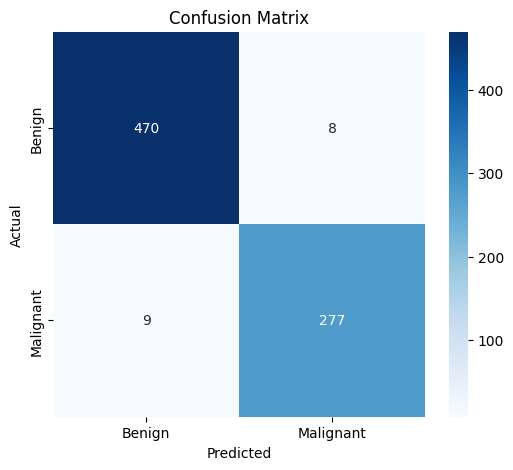

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# Accuracy & Loss Plots
epochs = range(1, len(train_acc_hist)+1)
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

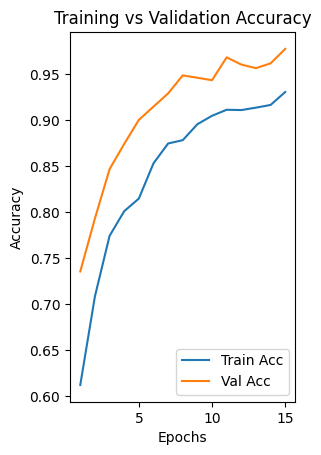

In [20]:
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_hist, label='Train Acc')
plt.plot(epochs, val_acc_hist, label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

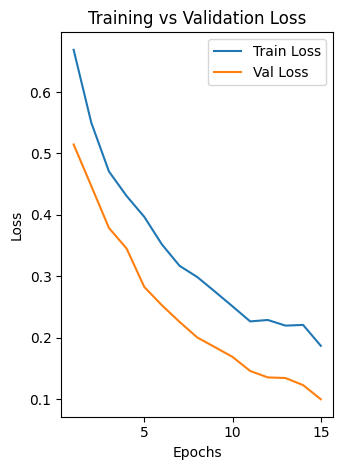

In [21]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

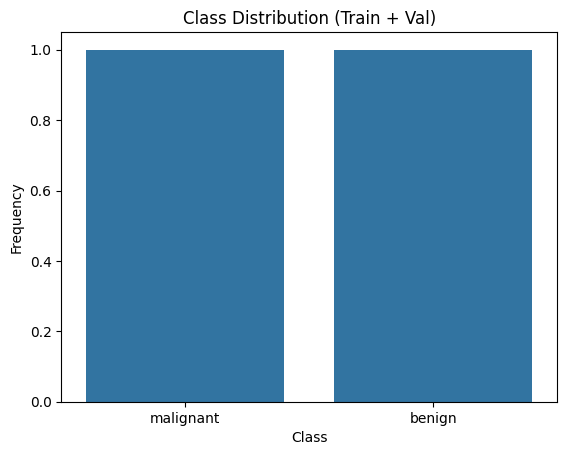

In [22]:
from collections import Counter
import seaborn as sns

# Assuming train dataset used for class balance
all_labels = ['malignant', 'benign']
class_counts = dict(Counter(all_labels))

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution (Train + Val)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
